# Evaluation of ion suppression correction

In this notebook, I explore different measures to quantify the effect of correcting SpaceM ion intensity data for partial pixel-cell overlap.
 

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.functions import *
from sklearn.cluster import KMeans
# import outer_spacem as osm

In [2]:
# def load_intensities_r(path):
#     intensities_df = pd.read_csv(path)
#     intensities_df.index = [ CELL_PRE + str(i) for i in intensities_df.cell]
#     intensities_df.pop('cell')
#     return intensities_df


# norm_ion_intensities = load_intensities_r('data/Mx_Co_Cultured/Martijns_results/raw_intensities_r.csv')
# norm_cor_ion_intensities = load_intensities_r('data/Mx_Co_Cultured/Martijns_results/cor_intensities_r.csv')
# norm_ion_intensities

In [3]:
norm_ion_intensities = pd.read_pickle('data/Mx_Co_Cultured/normalized_ion_intensities.pkl')
norm_cor_ion_intensities = pd.read_pickle('data/Mx_Co_Cultured/normalized_corrected_ion_intensities.pkl')
norm_ion_intensities


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
11,13596.942837,1428.374145,257.718710,258.382738,532.464210,1630.750671,578.519208,1181.717813,1033.696410,1434.286616,...,0.000000,0.000000,0.0,0.000000,88.995720,0.000000,0.0,1625.245675,1010.626148,73.307538
13,17670.517637,1882.289900,183.453329,420.682866,621.845601,1542.858834,735.962828,1477.690808,1507.989352,2118.928795,...,0.000000,85.142653,0.0,0.000000,44.218585,0.000000,0.0,1462.990732,991.393674,36.423724
14,48103.515562,8488.243352,0.000000,2074.471824,1374.013035,4684.221454,3679.705746,3992.360861,4572.239969,4898.500689,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,4024.967368,2035.756582,254.250992
15,22089.693860,2357.389425,134.785602,566.584494,703.782218,1482.680216,920.639606,1816.590522,2028.107047,2823.634960,...,0.000000,161.531269,0.0,0.000000,0.000000,0.000000,0.0,1369.842586,990.259174,7.437679
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,10713.040133,1107.562673,136.006934,244.460251,264.382746,1290.608465,811.149315,1392.181825,836.535349,1671.875419,...,60.929401,120.688745,0.0,40.213130,206.232707,0.000000,0.0,3152.038702,2016.633720,166.406591
1503,19538.958672,1901.465852,274.487016,460.774021,299.667851,1673.652219,1447.091279,1890.548047,1553.920692,3192.398314,...,20.251164,116.953610,0.0,0.000000,0.000000,0.000000,0.0,3778.147267,2027.692022,156.318160
1510,8309.413000,777.507100,54.968914,0.000000,68.589830,1171.566900,582.492700,802.662400,265.930880,1357.944200,...,184.746340,134.135090,0.0,403.948850,0.000000,200.954740,0.0,7431.572300,3101.317100,669.905700
1512,8588.415299,818.901710,65.473625,31.426829,92.187044,1188.334279,612.567640,875.588029,333.607487,1393.266740,...,163.939956,128.241081,0.0,358.455581,28.164063,178.322944,0.0,6952.017040,2990.983805,609.175751


In [4]:
condition_name = 'celltype'

The conditions data for the co-culture datasets is established using fluorescence microscopy. The following code is adapted from Martijn and just shows the classification of fluorescence values to celltypes

HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


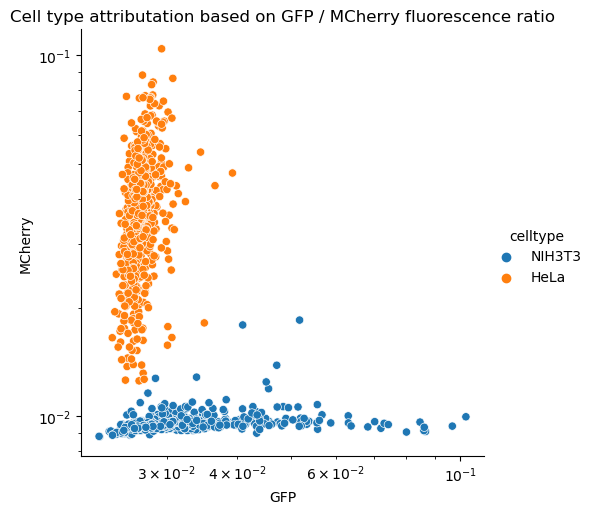

In [5]:
condition_metadata = pd.read_csv('data/Mx_Co_Cultured/MORPHnMOL.csv')
condition_metadata.index = [CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')

In [6]:
obs = condition_metadata[['ObjectNumber', 'celltype', 'GFP', 'MCherry', 'fluorescence_ratio']]
norm_ion_intensities
# condition_metadata.index = condition_metadata.index.map(str)
# norm_ion_intensities.index = norm_ion_intensities.index.map(str)

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
11,13596.942837,1428.374145,257.718710,258.382738,532.464210,1630.750671,578.519208,1181.717813,1033.696410,1434.286616,...,0.000000,0.000000,0.0,0.000000,88.995720,0.000000,0.0,1625.245675,1010.626148,73.307538
13,17670.517637,1882.289900,183.453329,420.682866,621.845601,1542.858834,735.962828,1477.690808,1507.989352,2118.928795,...,0.000000,85.142653,0.0,0.000000,44.218585,0.000000,0.0,1462.990732,991.393674,36.423724
14,48103.515562,8488.243352,0.000000,2074.471824,1374.013035,4684.221454,3679.705746,3992.360861,4572.239969,4898.500689,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,4024.967368,2035.756582,254.250992
15,22089.693860,2357.389425,134.785602,566.584494,703.782218,1482.680216,920.639606,1816.590522,2028.107047,2823.634960,...,0.000000,161.531269,0.0,0.000000,0.000000,0.000000,0.0,1369.842586,990.259174,7.437679
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,10713.040133,1107.562673,136.006934,244.460251,264.382746,1290.608465,811.149315,1392.181825,836.535349,1671.875419,...,60.929401,120.688745,0.0,40.213130,206.232707,0.000000,0.0,3152.038702,2016.633720,166.406591
1503,19538.958672,1901.465852,274.487016,460.774021,299.667851,1673.652219,1447.091279,1890.548047,1553.920692,3192.398314,...,20.251164,116.953610,0.0,0.000000,0.000000,0.000000,0.0,3778.147267,2027.692022,156.318160
1510,8309.413000,777.507100,54.968914,0.000000,68.589830,1171.566900,582.492700,802.662400,265.930880,1357.944200,...,184.746340,134.135090,0.0,403.948850,0.000000,200.954740,0.0,7431.572300,3101.317100,669.905700
1512,8588.415299,818.901710,65.473625,31.426829,92.187044,1188.334279,612.567640,875.588029,333.607487,1393.266740,...,163.939956,128.241081,0.0,358.455581,28.164063,178.322944,0.0,6952.017040,2990.983805,609.175751


The co-culture dataset was originally used in the original SpaceM manuscript. The corresponding metadata file `MORPHnMOL.csv` subsets the list of annotated molecules from 104 to 58. Consequently, only these molecules will be explored in the following. Analogously, only the cells present in both the uncorrected and corrected spatiomolecular matrices are kept for the analysis.

In [7]:
included_cells = norm_ion_intensities.index.intersection(obs.index)
all_molecules = norm_ion_intensities.columns
included_molecules = norm_ion_intensities.columns.intersection(condition_metadata.columns)



adata = ad.AnnData(X=norm_ion_intensities.loc[included_cells, all_molecules], obs=obs.loc[included_cells])
adata_cor = ad.AnnData(X=norm_cor_ion_intensities.loc[included_cells, all_molecules], obs=obs.loc[included_cells])

print(adata.shape)
print(adata_cor.shape)

(1207, 104)
(1207, 104)


/tmp/ipykernel_1824/708609319.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=norm_ion_intensities.loc[included_cells, all_molecules], obs=obs.loc[included_cells])
/tmp/ipykernel_1824/708609319.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_cor = ad.AnnData(X=norm_cor_ion_intensities.loc[included_cells, all_molecules], obs=obs.loc[included_cells])


In [8]:
excluded_molecules = all_molecules.difference(included_molecules)
excluded_molecules

Index(['C10H10N2O3S', 'C10H10N2O4S', 'C12H13N3O4S', 'C12H20N3O6S',
       'C13H16N2O5', 'C13H26O2', 'C14H20N2O3S', 'C14H20N2O4S', 'C14H20N2O6S',
       'C14H21N3O3S', 'C14H23N2O8', 'C14H28O2', 'C14H29NaO4S', 'C15H18O12',
       'C15H22O2', 'C15H30O2', 'C16H12N2', 'C16H15F2N3Si', 'C16H32O2',
       'C17H17ClN4', 'C18H13N3O', 'C20H12N2O2', 'C20H14N4', 'C20H18N4O2',
       'C20H32N5O8P', 'C21H20N4O2', 'C25H34O3', 'C25H36O2', 'C25H36O3',
       'C26H31NO11', 'C27H46O4', 'C34H38O16', 'C34H70NO6P', 'C39H36N4O7',
       'C39H78NO8P', 'C41H79O13P', 'C41H82NO7P', 'C42H79O10P', 'C43H74NO7P',
       'C43H74NO8P', 'C45H76NO7P', 'C45H78NO7P', 'C45H82NO7P', 'C46H77O10P',
       'C46H81NO10P', 'C50H84NO10P'],
      dtype='object')

In the following, both spatiomolecular matrices are filtered and scaled to zero-mean and unit variance.

In [9]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=5)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.raw = adata
    # sc.pp.normalize_total(adata, target_sum=None)
    # sc.pp.log1p(adata)
    sc.pp.scale(adata)

preprocess(adata)
preprocess(adata_cor)


print(adata.shape)
print(adata_cor.shape)


(1137, 104)
(1137, 104)


Here, we actually perform the subsetting of molecules.

In [10]:
def subset_molecules(adata):
    return adata[:, included_molecules]

adata = subset_molecules(adata)
adata_cor = subset_molecules(adata_cor)

print(adata.shape)
print(adata_cor.shape)

(1137, 58)
(1137, 58)


In the following graphs, the uncorrected data is shown before the corrected data. Initially, the data is visualized using PCA and UMAP

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


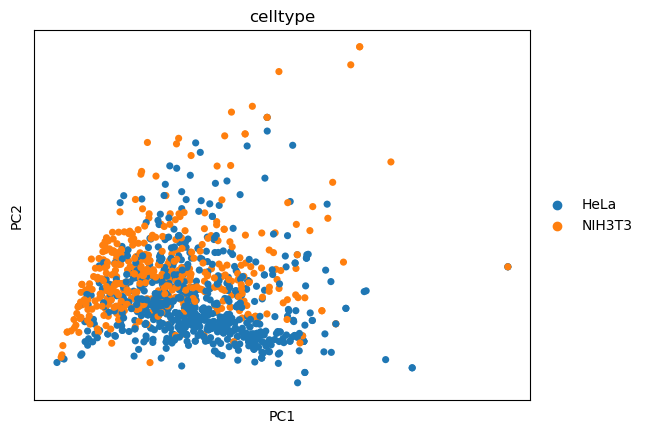

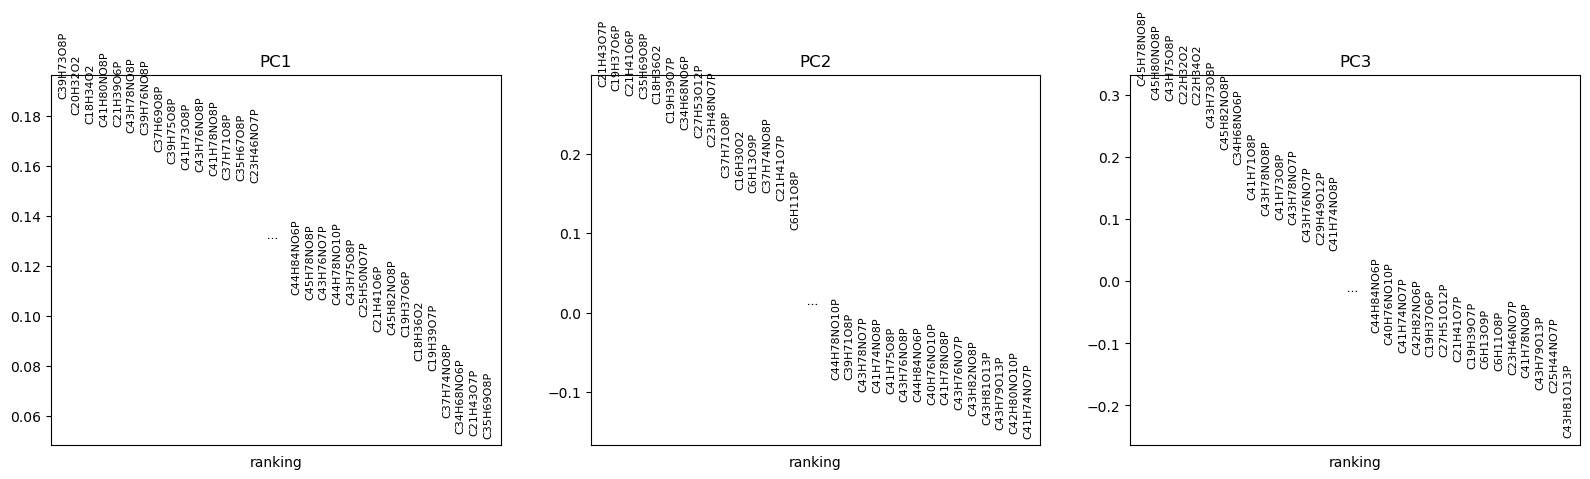

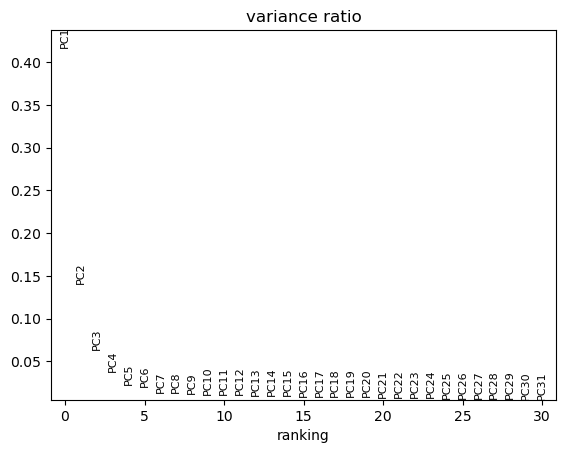

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


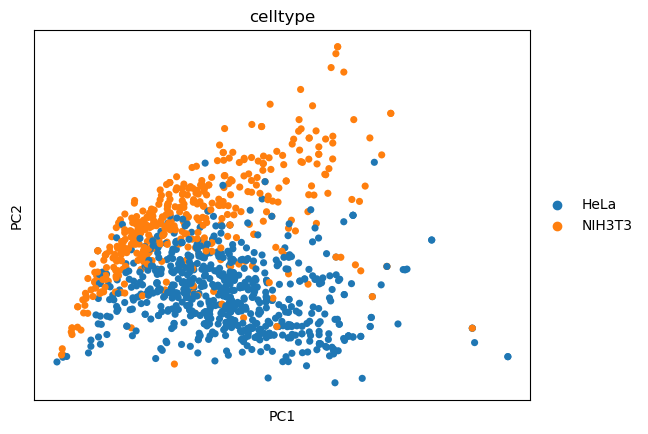

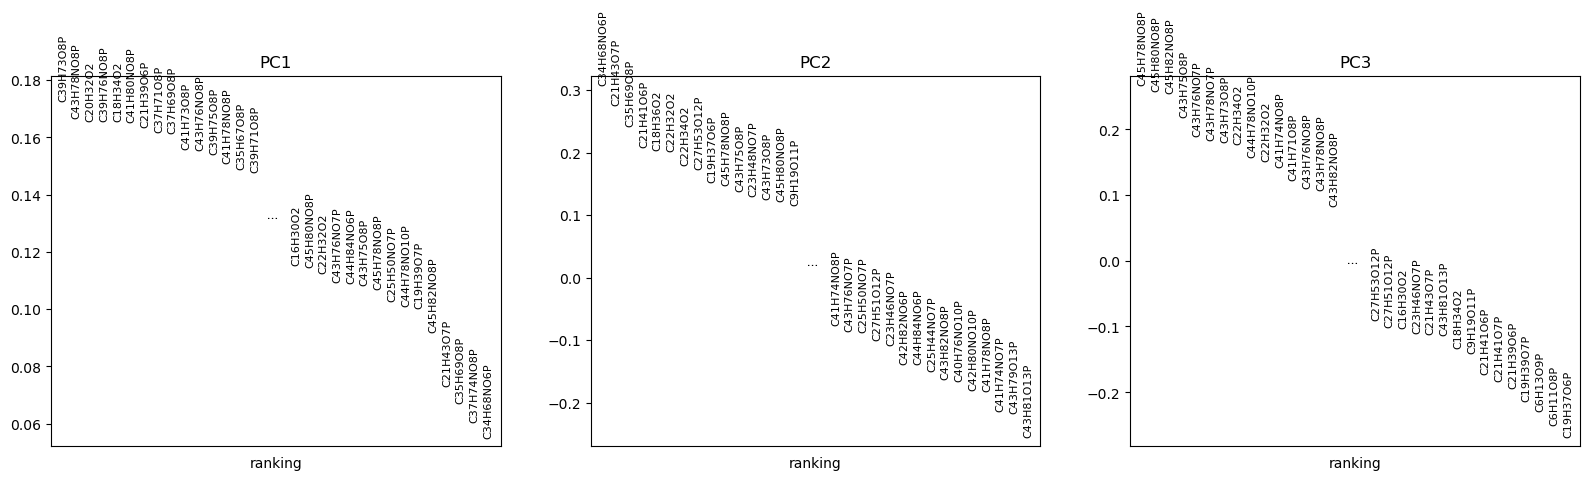

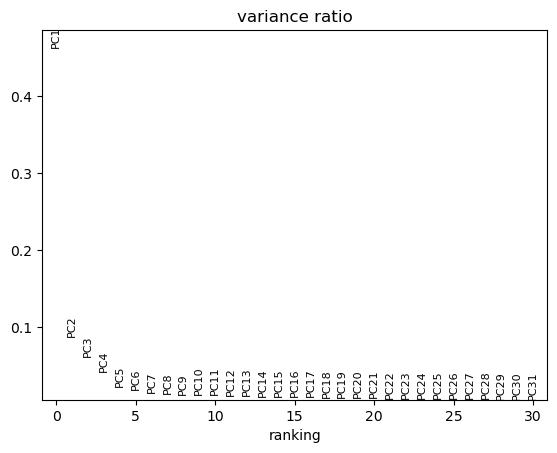

In [11]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color='celltype')

dimred_pca(adata)
dimred_pca(adata_cor)

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


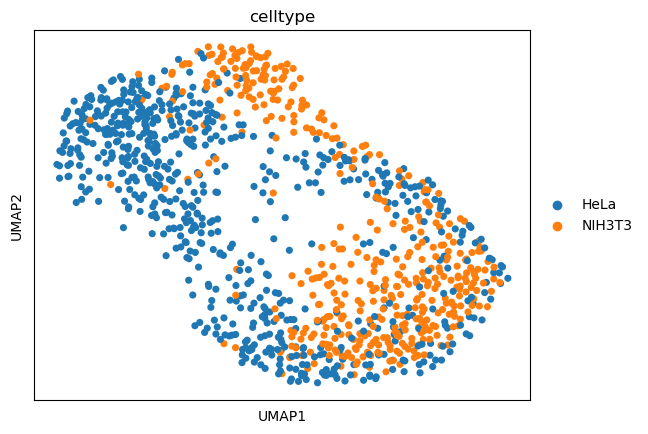

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


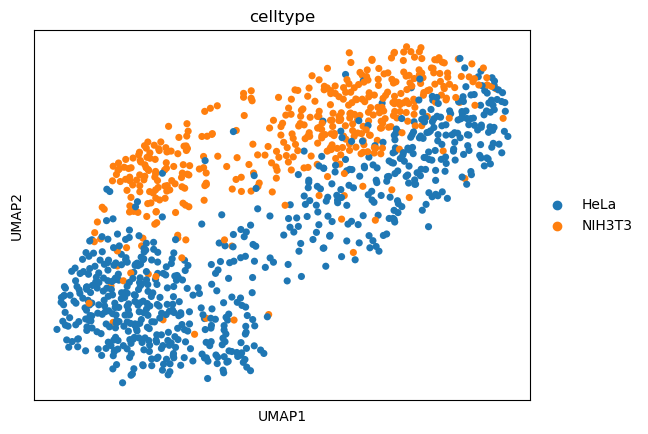

In [12]:
def dimred_umap(adata, min_dist = 0.5):
    sc.pp.neighbors(adata, n_neighbors=200, metric='cosine')
    sc.tl.umap(adata, min_dist=min_dist, spread=2.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color=condition_name)
    # f = osm.pl.highlight_scatterplot(
    #     data = adata,
    #     obsm_key = "X_umap",
    #     hue = condition_name,
    #     col = condition_name,
    #     palette = "cividis",
    #     height = 5,
    #     scatter_kwargs = dict(s=10)
    # )

    # f.add_legend(markerscale=3)

    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

dimred_umap(adata)
dimred_umap(adata_cor)


There exist several methods for unsupervised clustering, that can be applied to dimensionality-reduced data. Here, I show kMeans clustering, Leiden clustering and a variant of the latter (adapted from the SpaceM manuscript: curated leiden). Both kMeans and Leiden clustering appear to fail at distinguishing the two celltypes as they split the data along the short axis of the UMAP visualization. However, the celltypes are separated along the long axis. The curated Leiden algorithm from Rappez et al. finds smaller Leiden clusters and assigns them to either celltype depending on the nature of the majority of cells. This method of finer granularity does better reproduce the separation between the two celltypes.

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


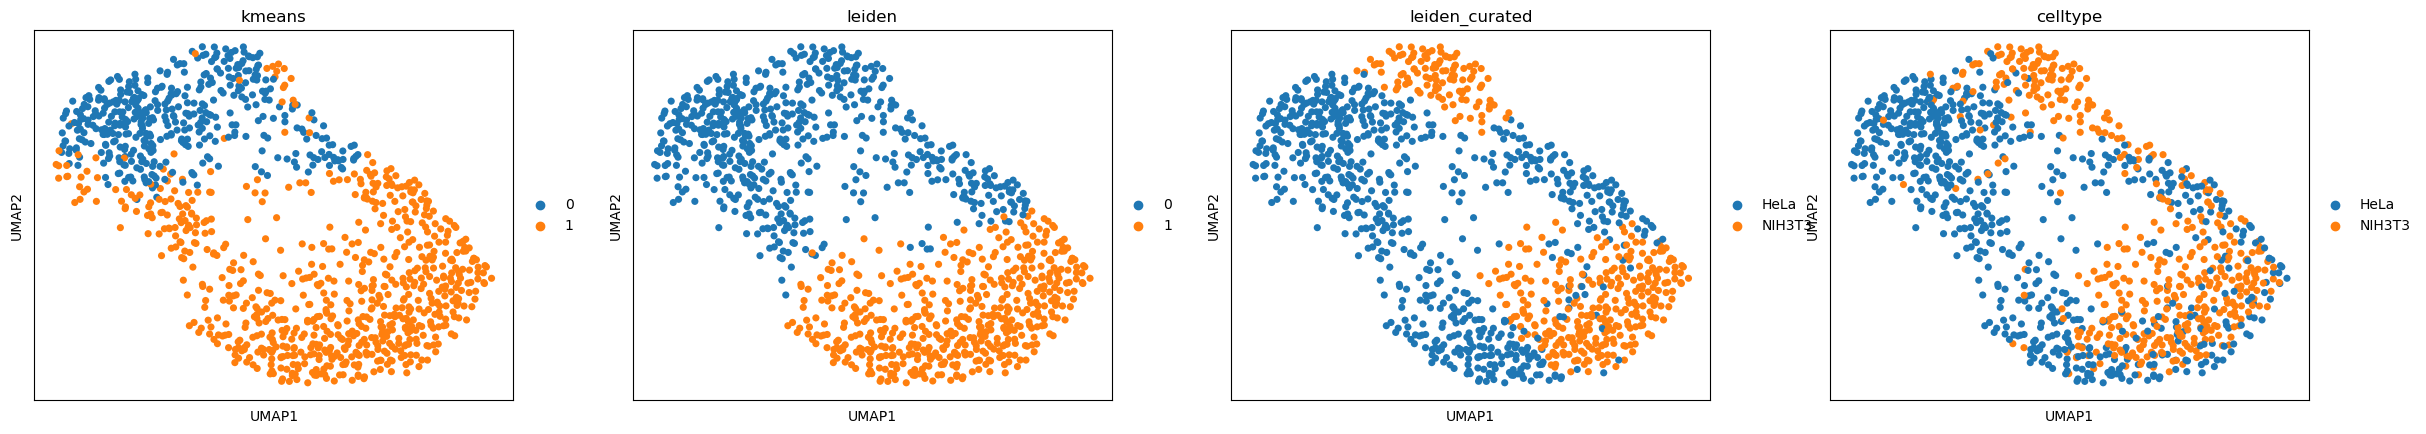

Leiden acccuracy score: 0.6420
Curated leiden acccuracy score: 0.8215
KMeans completeness score: 0.0199
KMeans silhouette coefficient: 0.2681


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


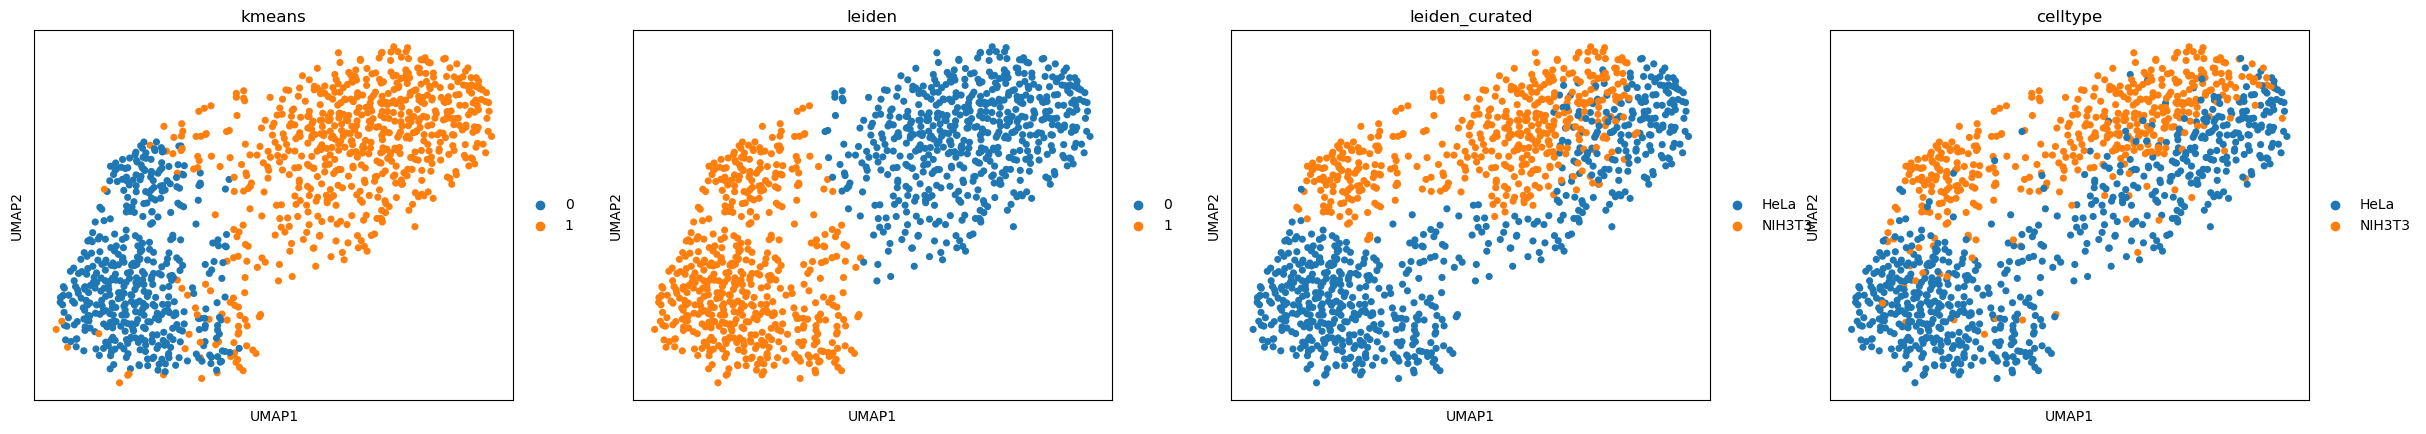

Leiden acccuracy score: 0.3835
Curated leiden acccuracy score: 0.8487
KMeans completeness score: 0.0356
KMeans silhouette coefficient: 0.2661


In [13]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score, silhouette_score

def clustering_methods(adata):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=0.3)
    sc.tl.leiden(adata, resolution=2, key_added='leiden_fine')

    leiden = np.array(adata.obs['leiden_fine'].values)
    leiden_curated = np.copy(leiden)
    fc = np.array(adata.obs['celltype'].values)
    for cluster in np.unique(leiden):
        labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
        leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
    adata.obs['leiden_curated'] = leiden_curated

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'leiden_curated', 'celltype'])
    print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('Curated leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'], y_pred = adata.obs['leiden_curated']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs['celltype'], adata.obs['kmeans']))
    print('KMeans silhouette coefficient: %1.4f' % silhouette_score(adata.X, adata.obs['kmeans']))

clustering_methods(adata)
clustering_methods(adata_cor)


Linear discriminant analysis is a linear classifier that can be trained and applied to the ion intensity data in order to further examine the separation of the different conditions (celltypes). In general, the performance of the classifier depends on the underlying data, the trained model and how they work with each other. Assuming the model itself has equal performance in both cases, higher the accuracy of the classifier can be attributed to a better separation of the data.

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


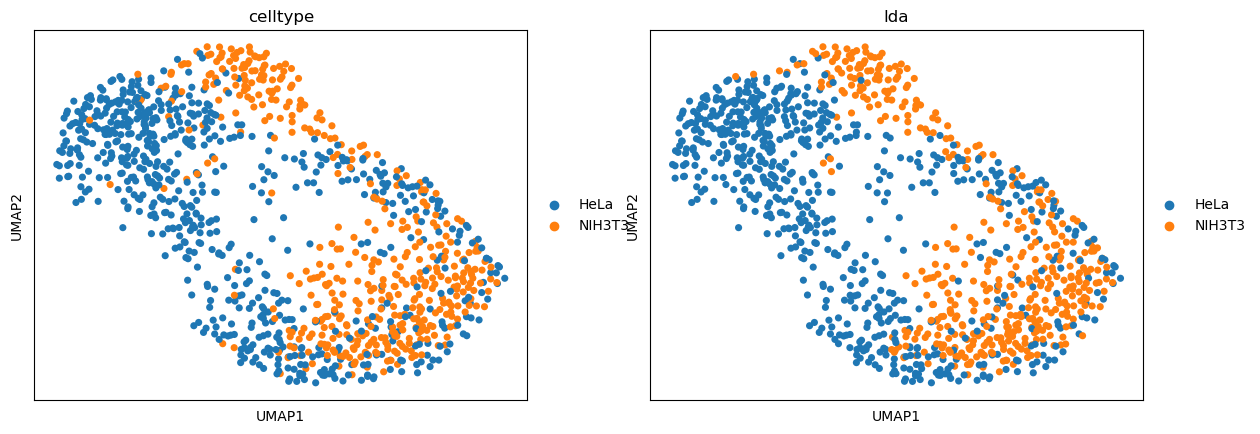

LDA accuracy after 10-fold cross-validation: 0.9177 (±0.0245)


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


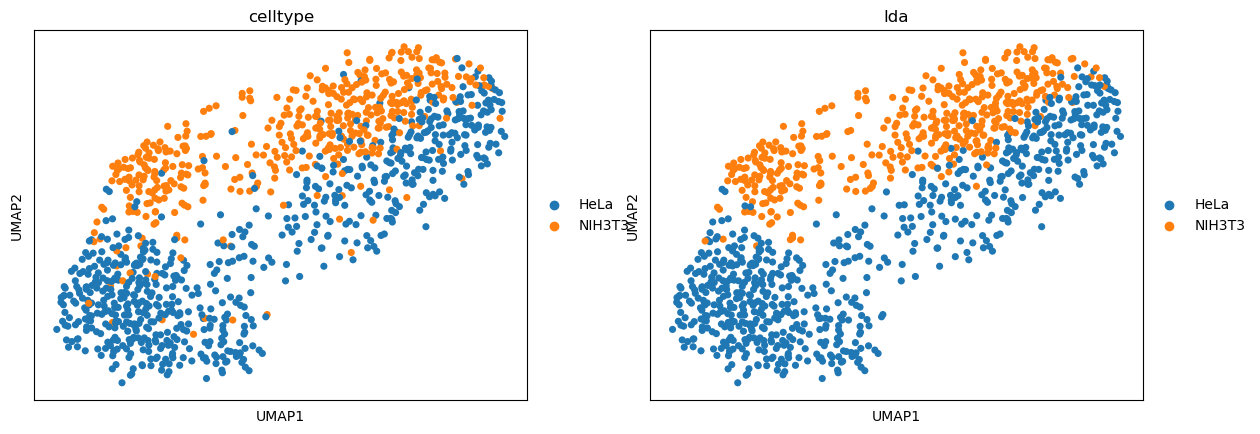

LDA accuracy after 10-fold cross-validation: 0.9124 (±0.0247)


In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def LDA(adata):
    predictors = adata.X
    result = adata.obs['celltype']
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=10)
    
    adata.obs['lda'] = model.predict(adata.X)
    sc.pl.umap(adata, color=['celltype', 'lda'])
    print("LDA accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  


LDA(adata) 
LDA(adata_cor) 

Finally, Martijn developed an intermixing metric for the separation of different conditions based on the local neighborhood (euclidian distance) of every data point in dimensionality-reduced space. I have extended this single-valued measure to a curve on neighborhood-scale and introduced a correction factor for unbalanced datasets. For the co-culture dataset, this metric shows a clear difference in the group intermixing of uncorrected and corrected ion intensities. Intermixing is almost 50% lower after correction across neighborhood sizes.

227it [00:06, 34.42it/s]
227it [00:00, 304.55it/s]
227it [00:00, 335.55it/s]
227it [00:00, 379.80it/s]


,,mean,sd,rel_neighborhood
umap_1,10,0.258475,0.295179,0.091837
umap_2,10,0.158013,0.288106,0.091837
pca_1,10,0.200389,0.266097,0.091837
pca_2,10,0.191805,0.257433,0.091837


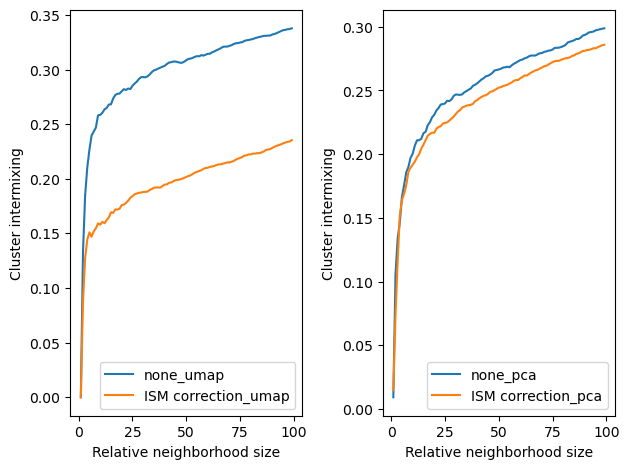

In [15]:
intermixing(adata, adata_cor, condition_name=condition_name, labels=('none', 'ISM correction'), sample_frac=0.2)

For a better comparison to Martijns results, I also calculate the intermixing metric for the fixed neighborhood of $n=10$, with and without normalization to group imbalance. Martijn reports intermixing values of $0.152$ for ISM correction and $0.215$ for uncorrected data.

In [16]:
pd.concat([intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=True),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=True),
intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=False),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=False)], axis=0, keys=['none', 'ISM', 'none_raw', 'ISM_raw'])

227it [00:00, 530.16it/s]
227it [00:00, 528.88it/s]
227it [00:00, 519.15it/s]
227it [00:00, 517.40it/s]


,,mean,sd,rel_neighborhood
none,10,0.258475,0.295179,0.0
ISM,10,0.158013,0.288106,0.0
none_raw,10,0.247577,0.267950,0.0
ISM_raw,10,0.149780,0.230308,0.0


As visible in UMAP space, the two celltypes are separated along the long axis of the cluster instead of the short axis. This may indicate that the metabolic profiles within two populations themselves are more heterogenic than between them. Thus an additional biological or technical factor seems to influence the metabolic profiles. To investigate this furter, I did a differential expression analysis between the two leiden clusters. On top of that, it would be useful to complement this with an enrichment analysis.


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.

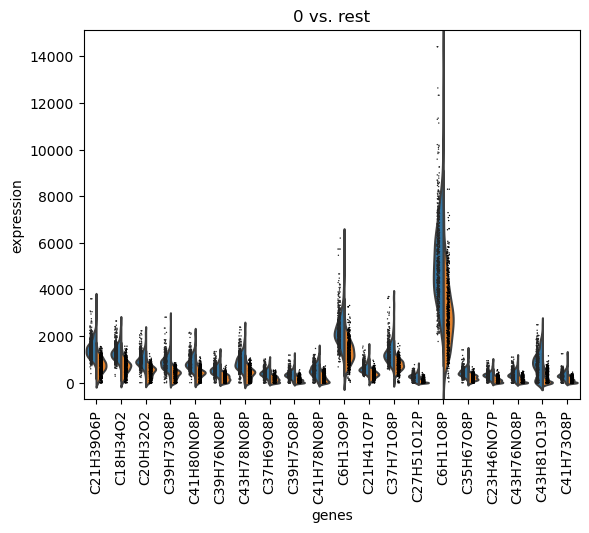

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


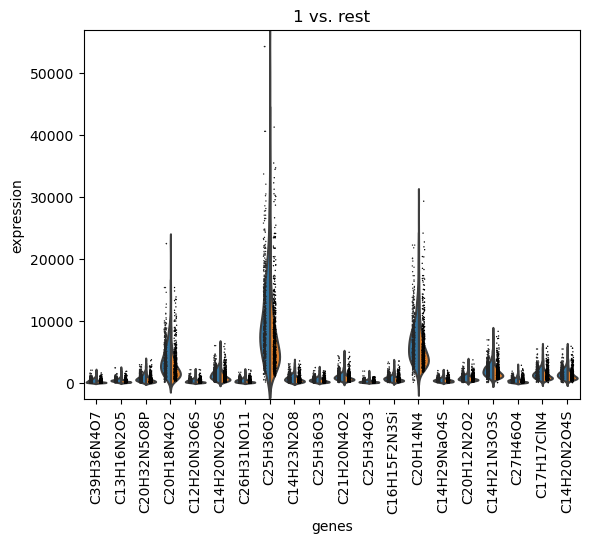

In [17]:
sc.tl.rank_genes_groups(adata=adata, groupby='leiden', use_raw=True, method='t-test_overestim_var', n_genes=25)
# sc.pl.rank_genes_groups_tracksplot(adata, groupby='leiden')
sc.pl.rank_genes_groups_violin(adata, groups=['0', '1'])
sc.get.rank_genes_groups_df(adata, group='0')['names'].to_csv('data/Mx_Co_Cultured/metabolite-set.csv')